In [39]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.decomposition import PCA

from lfpan import intact_files
from utils import get_filenames, get_kde
from loaders import StabilityRecording, StabilityDurationRecording

plt.style.use('pcb')

In [20]:
txt_files, abf_files = intact_files(leave_out=[9])

txt_files_stab = sorted(get_filenames('data/base recordings/stability', contains='txt'))
abf_files_stab = sorted(get_filenames('data/base recordings/stability', contains='abf'))

In [44]:
lfps_stab = {}
kde_xx = np.arange(-1, 3, 0.001)

for ix in range(1,4):
    rec = StabilityRecording(txt_files_stab[ix], abf_files_stab[ix], filtered=True, cutoff=15)
    lfps_stab[ix] = []
    
    for i in range(len(rec)):
        tarr, varr = rec[i][1].to_arrays()
        tarr = tarr - rec[i][0].stim_start
        varr = varr - varr[tarr < 0].mean()

        func = UnivariateSpline(tarr, varr, s=0, k=1)
        lfps_stab[ix].append(func(kde_xx))
    
    lfps_stab[ix] = np.array(lfps_stab[ix])

lfps_stab[2] = lfps_stab[2][:-1]

In [45]:
bw = 0.01

kdes_stab = {}

for ix in range(1,4):
    rec = StabilityRecording(txt_files_stab[ix], abf_files_stab[ix], filtered=True, cutoff=15)
    kdes_stab[ix] = []
    
    for i in range(len(rec)):
        sresp = rec[i][0]
        kde = sresp.kde(kde_xx, shift=True, bw=bw)
        kdes_stab[ix].append(kde)
    
    kdes_stab[ix] = np.array(kdes_stab[ix])

kdes_stab[2] = kdes_stab[2][:-1]

In [46]:
lfps = {}
kdes = {}
tarrs = {}

for dur in [0.02, 0.2, 2]:
    lfps[dur] = []
    kdes[dur] = []

bw = 0.01
kde_xx = np.arange(-1, 3, 0.001)

for txt_file, abf_file in zip(txt_files, abf_files):
    rec = StabilityDurationRecording(txt_file, abf_file, filtered=True, cutoff=15)
    
    for i in range(2):
        dur = 2
        sresp, lresp = rec[dur][i]

        tarr, varr = lresp.to_arrays()
        tarr = tarr - sresp.stim_start
        varr = varr - varr[tarr < 0].mean()

        func = UnivariateSpline(tarr, varr, s=0, k=1)

        lfps[dur].append(func(kde_xx))

        kde = sresp.kde(kde_xx, shift=True, bw=bw)
        kdes[dur].append(kde)

        tarrs[dur] = tarr

X_lfp = np.array(lfps[2]).reshape((2,len(txt_files),-1)).mean(axis=0)
X_kde = np.array(kdes[2]).reshape((2,len(txt_files),-1)).mean(axis=0)

In [47]:
decomposer_lfp = PCA(n_components=4)
decomposer_kde = PCA(n_components=4)

coords_lfp = decomposer_lfp.fit_transform(X_lfp)
coords_kde = decomposer_kde.fit_transform(X_kde)

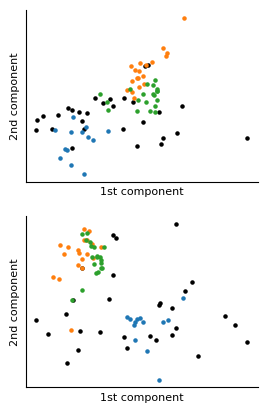

In [48]:
fig, axes = plt.subplots(nrows=2, figsize=(3,5))

def plot_pca(axes):
    scatter_params = {'marker': 'o', 's': 5}

    for ax, coords, stab, decomposer in zip(axes, [coords_lfp, coords_kde], [lfps_stab, kdes_stab], [decomposer_lfp, decomposer_kde]):
        ax.scatter(*coords.T[:2], **scatter_params, color='black')

        for i in range(1, 4):
            coords_stab = decomposer.transform(stab[i])
            ax.scatter(*coords_stab.T[:2], **scatter_params)
            
        ax.set_xlabel('1st component')
        ax.set_ylabel('2nd component')
        ax.set_xticks([])
        ax.set_yticks([])
    
plot_pca(axes)

In [49]:
def resp2kde(resp, tarr, bw=0.05):
    st = resp.spiketrain - resp.stim_start
    kde = get_kde(tarr, st, bw)
    return kde

def average_kde(rec, bw=0.05):
    tarr = np.linspace(-1, 5, 500)
    kdes = []
    for i in range(len(rec)):
        resp = rec[i][0]
        kde = resp2kde(resp, tarr, bw)
        if kde.mean() > 1:
            kdes.append(kde)
    
    return tarr, np.mean(kdes, axis=0), kdes

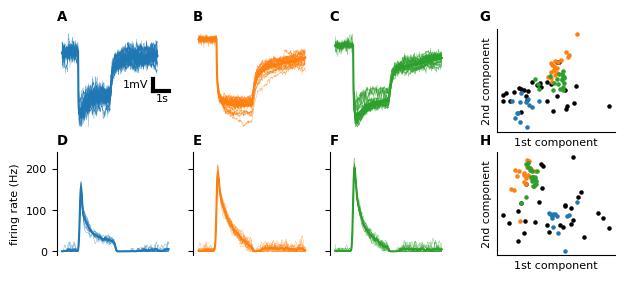

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(7.2, 3), gridspec_kw={'width_ratios': [1,1,1,0.1,1]})


def plot_ix(ix, axes, color):
    filtered_arr = []
    rec = StabilityRecording(txt_files_stab[ix], abf_files_stab[ix], filtered=True, cutoff=200)

    tarr, mean_kde, kdes = average_kde(rec)
    axes[1].plot(tarr+1, mean_kde, c=color)

    for kde in kdes:
        axes[1].plot(tarr+1, kde, c=color, lw=0.2)

    max_len = 60000

    for i in range(len(rec)):
        _tarr, varr = rec[i][1].to_arrays()
        _tarr = _tarr - rec[i][0].stim_start
        varr = varr - varr[_tarr < 0].mean()
        func = UnivariateSpline(_tarr, varr, s=0, k=1, ext=2)
        try:
            filtered = func(tarr)
        except ValueError:
            break
        filtered_arr.append(filtered)
        axes[0].plot(tarr, filtered, c=color, lw=0.2)

    filtered = np.mean(filtered_arr, axis=0)
    axes[0].plot(tarr, filtered, c=color)

plot_ix(1, axes[:,0], 'C0')
plot_ix(2, axes[:,1], 'C1')
plot_ix(3, axes[:,2], 'C2')

# axes[1,0].plot([1.5, 3.5], [-3.3, -3.3], color='black', ls='dashed')
axes[1,0].set_ylabel('firing rate (Hz)')
for i in range(3):
    axes[1,i].set_ylim(-10,240)
    
    axes[1,i].spines['bottom'].set_visible(False)
    axes[1,i].set_xticks([])
    
    axes[0,i].spines['bottom'].set_visible(False)
    axes[0,i].spines['left'].set_visible(False)
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    
    if i != 0:
        axes[1,i].set_yticklabels([])

axes[0,0].plot([4.7,5.7],[-3,-3], color='black', lw=3)
axes[0,0].plot([4.7,4.7],[-2,-3], color='black', lw=3)
axes[0,0].text(2.8, -2.7, '1mV')
axes[0,0].text(4.9, -3.8, '1s')

scatter_params = {'marker': 'x', 's': 7}

axes_pca = [axes[0,4], axes[1,4]]

plot_pca(axes_pca)


axes[0,3].remove()
axes[1,3].remove()

letters = ['A','B','C','D','E','F']

for l, ax in zip(letters, axes[:,:3].flat):
    ax.set_title(l, fontweight='bold', loc='left')

for l, ax in zip(['G','H'], axes[:,-1].flat):
    ax.set_title(l, fontweight='bold', loc='left', x=-.15)

fig.align_ylabels(axes[:, 4])

# plt.savefig('img/sp_heterogeneity.png')